In [1]:
%matplotlib widget
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import simple_pinn
import utils
import cv_mesh
import cv_solver
import athena_reader

# for dev purposes, reload these modules each time this cell is run
import importlib
importlib.reload(simple_pinn)
importlib.reload(utils)
importlib.reload(cv_mesh)
importlib.reload(cv_solver)
importlib.reload(athena_reader)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu" 

# torch.set_default_dtype(torch.float64)

In [2]:
x_domain = y_domain = [0, 1]
Nx_sample = Ny_sample = 100
mesh = cv_mesh.CVMesh(
    x_domain,
    y_domain,
    Nx_sample,
    Ny_sample,
    quad_pts=(4, 4),
    quad_rule="composite_trapezoid",
    requires_grad=True,
)
mesh.to(DEVICE)

In [3]:
K_0 = 1.0
K_1 = 4.0


def synthetic_data(inputs, eos=None):
    return torch.where(
        inputs[..., 0] < 0.5, inputs[..., 0], 0.5 + (K_0 / K_1) * (inputs[..., 0] - 0.5)
    ).unsqueeze(-1)


def synthetic_data_derivatives(inputs, eos=None):
    return torch.where(
        inputs[..., 0] < 0.5,
        torch.ones_like(inputs[..., 0]),
        K_0 / K_1 * torch.ones_like(inputs[..., 0]),
    ), torch.zeros_like(inputs[..., 0])


def true_K(inputs, eos=None):
    return torch.where(
        inputs[..., 0] < 0.5,
        K_0 * torch.ones_like(inputs[..., 0]),
        K_1 * torch.ones_like(inputs[..., 0]),
    )

In [4]:
u_model = simple_pinn.DirichletPINN(
    2,
    # [64, 64, 64, 64, 64, 64, 64, 64],
    [32, 32, 32, 32],
    1,
    mesh,
    synthetic_data,
    None,
    activation=torch.nn.Tanh(),
    # use_bias_in_output_layer=True,
    upwind_only=False,
).to(DEVICE)

K_model = simple_pinn.SegmentationPINN(
    2,
    # [64, 64, 64, 64, 64, 64, 64, 64],
    [32, 32, 32, 32],
    torch.tensor([K_0, K_1]).reshape(2, 1),
    activation=torch.nn.Tanh(),
).to(DEVICE)

model = simple_pinn.CombinedPINN(u_model, K_model).to(DEVICE)

In [5]:
def state_vec_to_fluxes(state_vec, eos, inputs):
    K = state_vec[..., 0]
    u = state_vec[..., 1]
    u_x = torch.autograd.grad(
        u, inputs, torch.ones_like(u), retain_graph=True, create_graph=True
    )[0][..., 0]
    u_y = torch.autograd.grad(
        u, inputs, torch.ones_like(u), retain_graph=True, create_graph=True
    )[0][..., 1]
    x = inputs[..., 0]
    y = inputs[..., 1]
    is_bc = torch.logical_or(
        torch.logical_or(x <= x_domain[0], x >= x_domain[1]),
        torch.logical_or(y <= y_domain[0], y >= y_domain[1]),
    )
    u_x_bc, u_y_bc = synthetic_data_derivatives(inputs)
    # print(is_bc.shape, u_x.shape, u_y.shape, u_x_bc.shape, u_y_bc.shape)
    u_x = torch.where(is_bc, u_x_bc, u_x)
    u_y = torch.where(is_bc, u_y_bc, u_y)
    K_bc = true_K(inputs)
    K = torch.where(is_bc, K_bc, K)
    F_x = (-K * u_x).unsqueeze(-1)
    F_y = (-K * u_y).unsqueeze(-1)
    return F_x, F_y

In [6]:
(
    F_x_eval_points,
    F_y_eval_points,
    _,
    _,
    _,
    _,
) = mesh.get_training_eval_points_and_weights()

eval_points = torch.cat(
    [F_x_eval_points.reshape(-1, 2), F_y_eval_points.reshape(-1, 2)], dim=0
)


def model_to_data_comparison(model, eos=None):
    return u_model(eval_points), synthetic_data(eval_points, eos)

In [7]:
solver = cv_solver.CVSolver(
    mesh,
    model,
    state_vec_to_fluxes,
    synthetic_data,
    None,
    model_to_data_comparison=model_to_data_comparison,
)

In [8]:
def train(n_epochs, lr_u, lr_K=None):
    if lr_K is None:
        lr_K = lr_u
    optimizer = optim.Adam(
        [
            {"params": u_model.parameters(), "lr": lr_u},
            {"params": K_model.parameters(), "lr": lr_K},
        ]
    )
    for epoch in range(n_epochs):
        cv_pde_loss, data_loss = solver.forward()
        optimizer.zero_grad()
        loss = cv_pde_loss + 1e-4 * data_loss
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            Ks = K_model(eval_points).detach().cpu()
            problem_parameters = K_model.problem_parameters.cpu()
            print(
                f"Epoch {epoch}: PDE loss: {cv_pde_loss.item():.3e}"
                f" Data loss: {data_loss.item():.3e}"
                f" K range: {Ks.min().item():.3f} -- {Ks.max().item():.3f}"
                f" Mean K: {torch.mean(Ks).item():.3f}"
                # f" Problem parameters: {problem_parameters}"
            )

In [9]:
train(2000, 1e-2)
train(5_000, 1e-3)
train(5_000, 1e-4)
train(20_000, 1e-5)

Epoch 0: PDE loss: 1.647e-02 Data loss: 1.098e+04 K range: 2.959 -- 3.072 Mean K: 3.031
Epoch 100: PDE loss: 2.340e-03 Data loss: 1.626e+01 K range: 1.145 -- 3.991 Mean K: 2.205
Epoch 200: PDE loss: 9.964e-04 Data loss: 1.960e+01 K range: 1.043 -- 3.998 Mean K: 2.054
Epoch 300: PDE loss: 5.725e-04 Data loss: 1.641e+01 K range: 1.029 -- 3.999 Mean K: 2.093
Epoch 400: PDE loss: 1.923e-04 Data loss: 1.108e+01 K range: 1.018 -- 3.999 Mean K: 2.306
Epoch 500: PDE loss: 1.167e-04 Data loss: 1.041e+01 K range: 1.009 -- 3.999 Mean K: 2.356
Epoch 600: PDE loss: 2.834e-04 Data loss: 1.490e+01 K range: 1.007 -- 3.999 Mean K: 2.252
Epoch 700: PDE loss: 5.319e-05 Data loss: 8.757e+00 K range: 1.004 -- 4.000 Mean K: 2.404
Epoch 800: PDE loss: 3.116e-05 Data loss: 6.496e+00 K range: 1.002 -- 3.999 Mean K: 2.356
Epoch 900: PDE loss: 8.570e-05 Data loss: 8.979e+00 K range: 1.004 -- 3.999 Mean K: 2.352
Epoch 1000: PDE loss: 2.833e-05 Data loss: 5.309e+00 K range: 1.002 -- 4.000 Mean K: 2.351
Epoch 1100:

In [10]:
n_epochs = 20_000

In [11]:
x, y, inputs = mesh.get_eval_points()

In [12]:
def plot_K_grid(K_grid, epoch):
    plt.imshow(
        K_grid.squeeze().T,
        origin="lower",
        extent=[x_domain[0], x_domain[1], y_domain[0], y_domain[1]],
        cmap="viridis",
        vmin=K_0,
        vmax=K_1,
    )
    plt.colorbar(label="K_grid")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"K_grid (Epoch {epoch})")
    plt.xticks([0, 0.25, 0.5, 0.75, 1])

In [13]:
def plot_u_grid(u_model, epoch):
    u_grid = u_model(inputs).detach().cpu()
    u_gt = synthetic_data(inputs).detach().cpu()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    im1 = ax1.imshow(
        u_grid.squeeze().T,
        origin="lower",
        extent=[x_domain[0], x_domain[1], y_domain[0], y_domain[1]],
        cmap="viridis",
    )
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    ax1.set_title(f"u_grid (Epoch {epoch})")
    ax1.set_xticks([0, 0.25, 0.5, 0.75, 1])

    im2 = ax2.imshow(
        u_gt.squeeze().T,
        origin="lower",
        extent=[x_domain[0], x_domain[1], y_domain[0], y_domain[1]],
        cmap="viridis",
    )
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_title(f"u_gt (Epoch {epoch})")
    ax2.set_xticks([0, 0.25, 0.5, 0.75, 1])

    # Create a shared colorbar
    cbar = fig.colorbar(im2, ax=[ax1, ax2], label="u_grid")

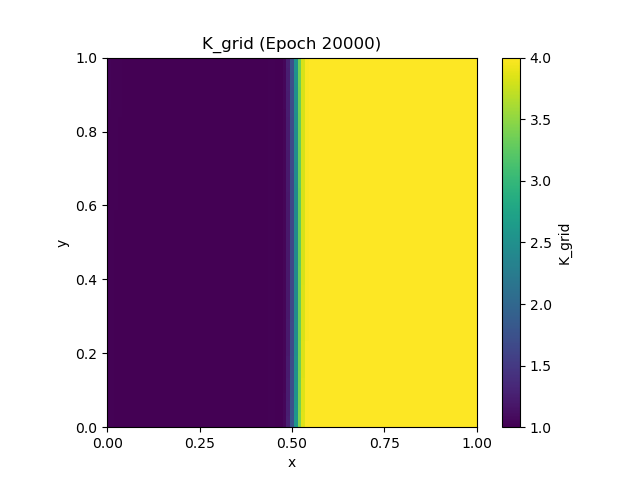

In [14]:
K_grid = K_model(inputs).detach().cpu()
plot_K_grid(K_grid, n_epochs)
plt.show()

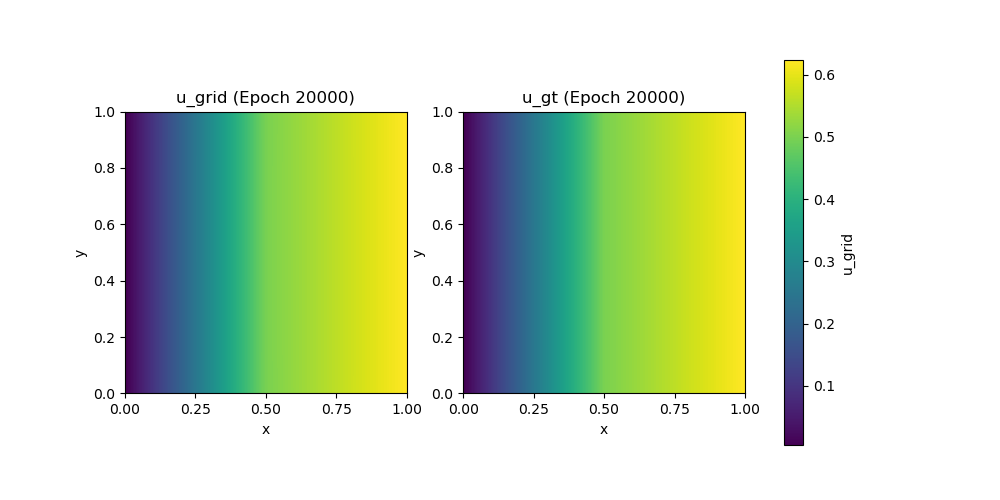

In [15]:
plot_u_grid(u_model, n_epochs)
plt.show()

NameError: name 'matplotlib' is not defined

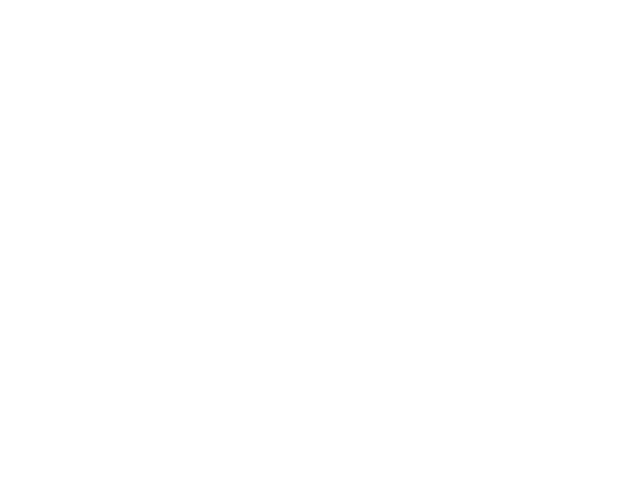

In [16]:
plt.figure()

# Define the y values for sampling
y_values = [0.1, 0.5, 0.9]

# Initialize an empty list to store the results
results = []

# Define a color map for assigning colors to y values
color_map = matplotlib.colormaps.get_cmap("tab10")

# Iterate over the y values and evaluate the model and synthetic data
for i, y in enumerate(y_values):
    # Create a tensor with the x values
    x_values = torch.linspace(x_domain[0], x_domain[1], 1000)

    # Create the inputs tensor
    plt_inputs = torch.stack((x_values, torch.full_like(x_values, y)), dim=-1).to(
        DEVICE
    )

    # Evaluate the model and synthetic data
    u_model_output = u_model(plt_inputs).detach().cpu().numpy()
    synthetic_data_output = synthetic_data(plt_inputs).detach().cpu().numpy()

    # Append the results to the list
    results.append(
        (x_values.numpy(), u_model_output.squeeze(), synthetic_data_output.squeeze(), y)
    )

# Plot the results
for i, (x_values, u_model_output, synthetic_data_output, y) in enumerate(results):
    color = color_map(i % color_map.N)  # Assign a unique color to each y value
    plt.plot(x_values, u_model_output, label=f"u_model (y={y:.2f})", color=color)
    plt.plot(
        x_values,
        synthetic_data_output,
        label=f"synthetic_data (y={y:.2f})",
        linestyle=":",
        color=color,
    )

plt.xlabel("x")
plt.ylabel("Output")
plt.title("Comparison of u_model and synthetic data")

# Place the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.show()

In [ ]:
plt.figure()

import numpy as np

# Define the y values for sampling
y_values = np.linspace(y_domain[0], y_domain[1], 10)

# Initialize an empty list to store the results
results = []

# Define a color map for assigning colors to y values
color_map = matplotlib.colormaps.get_cmap("tab10")

# Iterate over the y values and evaluate the model and synthetic data
for i, y in enumerate(y_values):
    # Create a tensor with the x values
    x_values = torch.linspace(x_domain[0], x_domain[1], 100)

    # Create the inputs tensor
    plt_inputs = torch.stack((x_values, torch.full_like(x_values, y)), dim=-1).to(
        DEVICE
    )

    # Evaluate the model and synthetic data
    K_grid_output = K_model(plt_inputs).detach().cpu().numpy()

    # Append the results to the list
    results.append((x_values.numpy(), K_grid_output.squeeze(), y))

# Plot the results
for i, (x_values, K_grid_output, y) in enumerate(results):
    color = color_map(i % color_map.N)  # Assign a unique color to each y value
    plt.plot(x_values, K_grid_output, label=f"y={y:.2f}", color=color)

plt.xlabel("x")
plt.ylabel("K_grid")
plt.title("K_grid as a function of x for various y")
plt.legend()

plt.show()